[View in Colaboratory](https://colab.research.google.com/github/YuliaZamriy/W207_Group_Project/blob/master/w207_openbarbell_baseline_submission_v2.ipynb)

# W207 Final Project
# Part 1: Exercise Classification

## 7 August 2018

### Project Description

OpenBarbell is a device that is used to record and measure key lifting metrics during a lifter's workout. Examples of user-entered metrics are weight, exercise label, and exercise tags. Examples of metrics captured through the device are range of motion (ROM), peak velocity and rep duration. A better understanding of these metrics can help lifters improve performance, prevent injury, build training programs, and streamline their workouts. The goal of this project is to use the data produced by OpenBarbell to add greater intelligence to the user experience.

### Project Goals

1. **Exercise classification**  
Build an algorithm to determine the exercise being performed. This serves two purposes and can be broken down into two subgoals:
   
    1. **Label existing data**  
        *Description:* Exercise names are acquired through user input. This field is freeform and completely optional. Hence, we would like to build an algorithm to determine the exercise for each rep based on its characteristics (weight, range of motion, velocity, etc.). This will allows us to reliably prepare and clean existing, mislabeled data.
   
        *Goal Benchmark:* Classify exercises with >70% accuracy
   
    2. **Real-time exercise logging**  
       *Description:* Workouts can require precise timing between exercises and repetitions. We also understand that workouts can be both physically and mentally exhausting. We would like to build a model that is able to take in device-captured data and classify the exercise in real-time. This would take that burden off of the user and allow them to better focus on their workout. 
   
       *Goal Benchmark:* Classify exercises in <1000ms
     
2. **Lifter segmentation**  
    *Description:* Every indivdual has their own unique combination of lifestyle habits, health goals, and athletic proficiency. Ideally, every person would have a customized training program to fit their needs. The precursor to a customized training program is getting a better understanding of the individual. We would like to create distinct groups of lifters based on their lifting characteristics for each exercise (weight, range of motion, velocity, etc.) as a way to segment populations of lifters.

    *Goal Benchmark:* Identify a users best lift, as determined by volume and weight


### Data and Source

 - [Project GitHub Repository](https://github.com/YuliaZamriy/W207_Group_Project)

### Team
 - Renzee Reyes
 - Tim Witthoefft
 - Jack Workman
 - Yulia Zamriy
 
## Summary, Next Steps, and Open Questions at the Bottom

**June's Comments**: 

- how are we going to help user? put it in project goals
- how are we dealing with sparse data?
- how much data is removed?  [DONE]
- present number of rows by each app version (if new version is majority of the data, it's ok to remove old version)  [DONE]
- null values chart: convert to percents
- show examples values for each label values
- add PeakVelAccel to summary
- include number of 0 values in .describe()
- add conclusions on data fidelity
- clarify what's happening on KNN/add conclusions
- check if different k values impact confusion matrix
- pull examples of misclassification between squats and deadlifts and maybe add a feature
- include the features that do most heavy lifting
- highlight the differences across models (include side by side charts)
- conclusions: how to tie it to user experience? what type of accuracy should we shoot for? should we introduce "uknown" exercise for low probability predictions
- remove ensemble logic... check if it actually improves
- instead focus on (1) basic feature engineering; (2) explaining why some models work better than others; (3) what's good accuracy for user experience? (4) lifter segmentation

In [1]:
import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import locale
import sys
import itertools
import json
import random
from locale import atof
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from IPython.display import display
from scipy.stats import mode
#from google.colab import files

#!pip install ipywidgets
from ipywidgets import IntProgress, HTML, VBox

%matplotlib inline

csv_data_file = 'ob_data_w207_filtered.csv'
zip_data_file = 'ob_data_w207_filtered.zip'

locale.setlocale(locale.LC_NUMERIC, '')

'en_US.UTF-8'

In [2]:
# Jupyter viewing options
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
pd.set_option('display.max_columns', 500)

# 1. Import Processed Data

At this stage, we are following up on the work performed in the data processing notebook, which produces a csv file of clean and transformed data. Please refer to the data processing notebook for more detail on how the csv file is produced. Otherwise, we can simply import the csv into our main dataframe.

In [59]:
df_main = None
if not os.path.exists(csv_data_file) and os.path.exists(zip_data_file):
    zip_ref = zipfile.ZipFile(zip_data_file, 'r')
    zip_ref.extractall()
    zip_ref.close()
if os.path.exists(csv_data_file):
    df_main = pd.read_csv(csv_data_file)
else:
    raise Exception('Data file not found! {0}'.format(csv_data_file))

# 2. Exploratory Data Analysis

To ensure that the data contains no hidden surprises, we do a quick EDA.

## 2.1 Shape and Head

In [3]:
print("Data shape: {0}".format(df_main.shape))

Data shape: (181224, 45)


In [4]:
df_main.head()

,Unnamed: 0,_id,deleted,endTime,exercise,initialStartTime,metric,removed_set,reps,rpe,...,PeakAccel,RepDur,TimeBWReps,TimeRepComp,TimeRepWait,SlowAllow,Backlight,MinAllow,setID_ix,RepCount
0,0,000051e0-54b2-48d8-98d2-79f65505c3e6,NaN,NaN,Bench,2018-01-03 01:29:46.904,kgs,0.0,"[{'isValid': True, 'removed': False, 'hardware...",7.5,...,11.073610,978699.0,0.0,1.752134e+09,0.0,130000.0,10000.0,150000.0,1,1.0
1,1,000051e0-54b2-48d8-98d2-79f65505c3e6,NaN,NaN,Bench,2018-01-03 01:29:46.904,kgs,0.0,"[{'isValid': True, 'removed': False, 'hardware...",7.5,...,0.714399,915894.0,0.0,1.754801e+09,0.0,130000.0,10000.0,150000.0,1,2.0
2,2,000051e0-54b2-48d8-98d2-79f65505c3e6,NaN,NaN,Bench,2018-01-03 01:29:46.904,kgs,0.0,"[{'isValid': True, 'removed': False, 'hardware...",7.5,...,0.730685,983460.0,0.0,1.757625e+09,0.0,130000.0,10000.0,150000.0,1,3.0
3,3,000051e0-54b2-48d8-98d2-79f65505c3e6,NaN,NaN,Bench,2018-01-03 01:29:46.904,kgs,0.0,"[{'isValid': True, 'removed': False, 'hardware...",7.5,...,0.923557,942963.0,0.0,1.760793e+09,0.0,130000.0,10000.0,150000.0,1,4.0
4,4,000051e0-54b2-48d8-98d2-79f65505c3e6,NaN,NaN,Bench,2018-01-03 01:29:46.904,kgs,0.0,"[{'isValid': True, 'removed': False, 'hardware...",7.5,...,0.827607,983978.0,0.0,1.764224e+09,0.0,130000.0,10000.0,150000.0,1,5.0


## 2.2 Check for Null Values

Here we observe that there are, in fact, quite a few null values in the dataset. Prior domain knowledge tells us that these are a result of older versions that do not support some of the newer fields and user input fields:

 - `endTime` and `startTime` replaced by `initialStartTime` and `time` in newer versions of the app
 - `rpe_num` (cleaned version of `rpe`) is entered through user input
 - `videoFileURL` and `videoType` are place holder for user's videos

These null values seen here can be safely ignored.

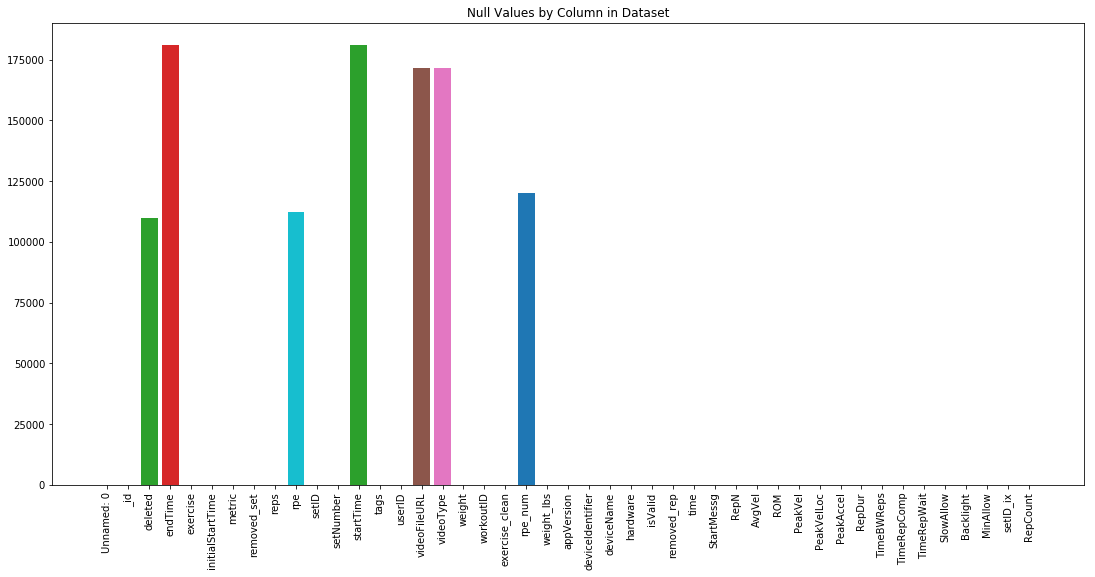

In [5]:
null_sums = df_main.isnull().sum()
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 8.5)
for i, null_col in enumerate(null_sums):
    plt.bar(i, null_col)

plt.title('Null Values by Column in Dataset')
plt.xticks(list(range(len(null_sums))), null_sums.index, rotation='vertical')
plt.show()

In [34]:
def get_descr(data, features=None):
    if features is None:
        features = data.columns
    data_descr = data[features].describe()
    pct_missing = pd.Series(100-np.around(data_descr.loc['count',]/data.shape[0]*100,2))
    pct_missing.name = 'pct_missing'
    pct_zero = pd.Series([100*sum(data[v] == 0)/data.shape[0] for v in features])
    pct_zero.name = 'pct_zeros'
    pct_zero.index = pct_missing.index
    data_descr = data_descr.append(pct_missing)
    data_descr = data_descr.append(pct_zero)
    return data_descr

get_descr(df_main, features=['deleted', 'endTime', 'removed_set', 'setNumber', 'startTime', 'rpe_num'
                             , 'weight_lbs', 'StartMessg', 'RepN', 'AvgVel', 'ROM', 'PeakVel', 'PeakVelLoc'
                             , 'PeakAccel', 'RepDur', 'TimeBWReps', 'TimeRepComp', 'TimeRepWait', 'SlowAllow'
                             , 'Backlight', 'MinAllow', 'setID_ix', 'RepCount'])

,deleted,endTime,removed_set,setNumber,startTime,rpe_num,weight_lbs,StartMessg,RepN,AvgVel,...,PeakAccel,RepDur,TimeBWReps,TimeRepComp,TimeRepWait,SlowAllow,Backlight,MinAllow,setID_ix,RepCount
count,71232.000000,0.0,181224.0,181224.000000,0.0,61034.000000,181224.000000,181224.000000,181224.000000,181224.000000,...,181224.000000,1.812240e+05,181224.000000,1.812240e+05,1.812240e+05,181224.000000,181224.000000,181224.000000,181224.000000,181224.000000
mean,0.000000,NaN,0.0,6.493941,NaN,7.266047,237.509353,-3219.539150,24.543455,0.468691,...,-467.837734,1.129646e+06,0.351256,1.706150e+09,2.795605e+05,129349.114167,9952.900095,149247.324686,24055.649169,3.375546
std,0.000000,NaN,0.0,5.946106,NaN,1.541093,106.705020,468.222607,24.490327,0.223723,...,1097.396166,4.931590e+05,5.669843,1.020477e+09,6.925327e+06,9147.219381,662.377762,10577.566980,13876.404474,3.284430
min,0.000000,NaN,0.0,1.000000,NaN,0.000000,1.000000,-3456.000000,1.000000,0.039064,...,-9999.000000,5.000000e+00,0.000000,-9.876000e+03,0.000000e+00,76.039300,76.039900,76.029900,1.000000,1.000000
25%,0.000000,NaN,0.0,2.000000,NaN,6.500000,165.000000,-3456.000000,8.000000,0.309058,...,1.182262,7.780158e+05,0.000000,9.008389e+08,0.000000e+00,130000.000000,10000.000000,150000.000000,12065.000000,1.000000
50%,0.000000,NaN,0.0,5.000000,NaN,7.500000,225.000000,-3456.000000,18.000000,0.421928,...,4.288830,1.065460e+06,0.000000,1.486152e+09,0.000000e+00,130000.000000,10000.000000,150000.000000,24033.000000,3.000000
75%,0.000000,NaN,0.0,9.000000,NaN,8.000000,308.646800,-3456.000000,33.000000,0.580345,...,9.837069,1.407044e+06,0.000000,2.375322e+09,0.000000e+00,130000.000000,10000.000000,150000.000000,36057.000000,4.000000
max,0.000000,NaN,0.0,169.000000,NaN,10.000000,1000.000000,-1234.000000,403.000000,2.960175,...,24150.160000,6.072204e+06,2295.000000,4.294947e+09,8.366950e+08,130000.000000,10000.000000,150000.000000,48128.000000,87.000000
pct_missing,60.690000,100.0,0.0,0.000000,100.0,66.320000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
pct_zeros,39.306052,0.0,100.0,0.000000,0.0,0.027590,0.000000,0.000000,0.000000,0.000000,...,0.004414,0.000000e+00,94.022867,0.000000e+00,8.639695e+01,0.000000,0.000000,0.000000,0.000000,0.000000


## 2.3 Target label variable

Our primary variable of interest is `exercise_clean`. As we can see based on table below, there are three possible values:

 - 3 *clean* values: **bench**, **deadlift**, **squat** where user entries for `exercise` were clean and specific 

In [35]:
def get_label_distribution(label):
    i, j = np.unique(label, return_counts = True)
    return pd.DataFrame({"Exercise": i, "Row count": j})
        
get_label_distribution(df_main['exercise_clean'])

,Exercise,Row count
0,bench,81938
1,deadlift,32540
2,squat,66746


## 2.4 Analyze Key Features

We are going to focus our analysis on the following set of features:

**Rep specific:**

 - `AvgVel`: Average velocity (m/s)
 - `ROM`: Range of motion (mm)
 - `PeakVel`: Peak Velocity (m/s) 
 - `PeakVelLoc`: Peak Velocity Location (%)
 - `PeakAccel`: Peak Acceleration (potentially drop as it has tracking issues)
 - `RepDur`: Duration of Rep (microseconds)

**Set specific:**

 - `weight_lbs`: weight (in lbs) for each set (user entry).

The following *rep* specific metrics have inconsistent data and are be dropped for now:
 - `TimeBWReps`: Time between Reps (minutes)
 - `TimeRepComp`: Timestamp of Rep Completion (microseconds)
 - `TimeRepWait`: Timestamp of time "waiting" in rep (microseconds)

In [37]:
df_main[['AvgVel', 'ROM', 'PeakVel', 'PeakVelLoc', 'RepDur', 'weight_lbs']].describe()

,AvgVel,ROM,PeakVel,PeakVelLoc,RepDur,weight_lbs
count,181224.000000,181224.000000,181224.000000,181224.000000,1.812240e+05,181224.000000
mean,0.468691,462.169144,0.759044,72.447121,1.129646e+06,237.509353
std,0.223723,155.470025,0.368769,19.757754,4.931590e+05,106.705020
min,0.039064,150.000000,0.034893,6.000000,5.000000e+00,1.000000
25%,0.309058,328.000000,0.473064,65.000000,7.780158e+05,165.000000
50%,0.421928,443.000000,0.706708,79.000000,1.065460e+06,225.000000
75%,0.580345,595.000000,0.966042,87.000000,1.407044e+06,308.646800
max,2.960175,1761.000000,5.329412,99.000000,6.072204e+06,1000.000000


# 3. Feature Engineer the Data

## 3.1 Trim Data to Key Features

In [69]:
key_features = ['AvgVel', 'ROM', 'PeakVel', 'PeakVelLoc', 'RepDur', 'weight_lbs']
primary_label = 'exercise_clean'
id_columns = ['setID_ix', 'RepCount']

# keep only the columns we care about
df_main = df_main[[primary_label] + key_features + id_columns]
print("Data shape after feature selection: {0}".format(df_main.shape))

Data shape after feature selection: (181224, 9)


## 3.2 Factorize Target Variable

In [65]:
# Factorize the primary label column
df_main[primary_label], labels_names = pd.factorize(df_main[primary_label], sort=True)

# Ensure that the new labels and counts align accurately
print(labels_names)
get_label_distribution(df_main[primary_label])

Index(['bench', 'deadlift', 'squat'], dtype='object')


,Exercise,Row count
0,0,81938
1,1,32540
2,2,66746


## 3.3 Feature Engineering

Todo!

In [ ]:
def feature_engineer_data(data):
    # todo
    return data

## 3.4 Describe Final Dataframe

In [45]:
df_main.describe()

,AvgVel,ROM,PeakVel,PeakVelLoc,RepDur,weight_lbs,setID_ix,RepCount
count,181224.000000,181224.000000,181224.000000,181224.000000,1.812240e+05,181224.000000,181224.000000,181224.000000
mean,0.468691,462.169144,0.759044,72.447121,1.129646e+06,237.509353,24055.649169,3.375546
std,0.223723,155.470025,0.368769,19.757754,4.931590e+05,106.705020,13876.404474,3.284430
min,0.039064,150.000000,0.034893,6.000000,5.000000e+00,1.000000,1.000000,1.000000
25%,0.309058,328.000000,0.473064,65.000000,7.780158e+05,165.000000,12065.000000,1.000000
50%,0.421928,443.000000,0.706708,79.000000,1.065460e+06,225.000000,24033.000000,3.000000
75%,0.580345,595.000000,0.966042,87.000000,1.407044e+06,308.646800,36057.000000,4.000000
max,2.960175,1761.000000,5.329412,99.000000,6.072204e+06,1000.000000,48128.000000,87.000000


# 4. Separate Data Into Train, Dev, & Test Sets

For this project, we are splitting the dataset into the following three categories:
1. Train - 80%
2. Dev - 10%
3. Test - 10%

Train will be used to train the model. We will use Dev to test our pipeline and model modifications. We will use Test as a final checkpoint of model performance.


## 4.1 Shuffle and Partition Dataset

In [94]:
def partition_data(data, labels, dev_pct, test_pct, seed):
    """
    Partitions input dataset into training, development and testing 
    
    Args:
        data: feature dataset
        labels: array of target labels
        dev_pct: float, percent of data to allocate to development
        test_pct: float, percent of data to allocate to testing
        seed: int, random seed
        
    Returns:
        6-tuple with 3 feature datasets and 3 target label arrays
    """
    
    data_shuffled = [data for _, data in data.groupby('setID_ix')]
    random.seed(seed)
    random.shuffle(data_shuffled)
    data_shuffled = pd.concat(data_shuffled)

    labels_shuffled = []
    for row in data_shuffled.itertuples():
        labels_shuffled.append(labels[row.Index])
        
    data_shuffled = data_shuffled.reset_index(drop=True)

    dev_cnt = int(np.round(len(data_shuffled) * dev_pct))
    while (data_shuffled.iloc[dev_cnt]['setID_ix'] == data_shuffled.iloc[dev_cnt + 1]['setID_ix']):
        dev_cnt += 1
        
    test_cnt = int(np.round(len(data_shuffled) * test_pct))
    while (data_shuffled.iloc[dev_cnt + test_cnt]['setID_ix'] == data_shuffled.iloc[dev_cnt + test_cnt + 1]['setID_ix']):
        test_cnt += 1
    
    dev_data, dev_labels = data_shuffled[:dev_cnt], labels_shuffled[:dev_cnt]
    test_data, test_labels = data_shuffled[dev_cnt:dev_cnt + test_cnt], labels_shuffled[dev_cnt:dev_cnt + test_cnt]
    train_data, train_labels = data_shuffled[dev_cnt + test_cnt:], labels_shuffled[dev_cnt + test_cnt:]
    
    return train_data, test_data, dev_data, train_labels, test_labels, dev_labels


train_data, test_data, dev_data, train_labels, test_labels, dev_labels = partition_data(df_main, df_main[primary_label], .1, .1, 5)

print(f'Dev data & labels shapes: {dev_data.shape}, {len(dev_labels)}')
print(f'Test data & labels shapes: {test_data.shape}, {len(test_labels)}')
print(f'Train data & labels shapes: {train_data.shape}, {len(train_labels)}')


Dev data & labels shapes: (18124, 9), 18124
Test data & labels shapes: (18123, 9), 18123
Train data & labels shapes: (144977, 9), 144977


## 4.2 Standardize Training Dataset

In [95]:
def standardize_data(train_data, test_data, dev_data, data_fit):
    """
    Standardize dataset and apply it to the input datasets
    
    Args:
        train_data: train dataset to apply standardization to
        test_data: test dataset to apply standardization to
        dev_data: dev dataset to apply standardization to
        data_fit: dataset used to fit standardization
    
    Returns:
        None
    """
    
    scaler = preprocessing.StandardScaler().fit(data_fit[key_features])
    train_data[key_features] = scaler.transform(train_data[key_features])
    test_data[key_features] = scaler.transform(test_data[key_features])
    dev_data[key_features] = scaler.transform(dev_data[key_features])
    
#     print(f"Means of standardized features:\n {np.around(np.mean(train_data, axis = 0),2)}\n {np.around(np.mean(test_data, axis = 0),2)}\n {np.around(np.mean(dev_data, axis = 0),2)}")
#     print(f"STDV of transform features:\n {np.around(np.std(train_data, axis = 0),2)}\n {np.around(np.std(test_data, axis = 0),2)}\n {np.around(np.std(dev_data, axis = 0),2)}")


standardize_data(train_data, test_data, dev_data, train_data)

# 5. Train and Test the Model

## 5.1 Define general function for classfication

### TODO:

 - adjust `argv` to make it more general

In [85]:
# DROP

def make_classifier(classifier, train, train_labs, dev, dev_labs, lab_names, printout, *argv):
    
    
    if argv:
        clsf = classifier(argv[0])
        print(f"\nResults for key parameter value = {argv[0]}")
    else:
        clsf = classifier()
    clsf.fit(train, train_labs)
    pred_labs = clsf.predict(dev)
    print(f"Accuracy on non-training data: {clsf.score(dev, dev_labs)*100:.2f}%")
    
    if printout == True:
        get_performance(dev_labs, pred_labs, lab_names)
    
    return pred_labs

In [80]:
# borrowed from scikit learn tutorial
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

np.set_printoptions(precision=2)

def plot_confusion_matrix(true_labs, pred_labs,
                          lab_names,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    cm = confusion_matrix(true_labs, pred_labs)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(lab_names))
    plt.xticks(tick_marks, lab_names, rotation=45)
    plt.yticks(tick_marks, lab_names)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [78]:
def get_performance(true_labs, pred_labs, lab_names):

    print("="*50)
    print("Classification report by exercise:")
    print(classification_report(true_labs, pred_labs, target_names=lab_names))
    print("="*50)
    print("Confusion matrix:")
    print(pd.DataFrame(confusion_matrix(true_labs, pred_labs), columns=lab_names, index=lab_names))
    plot_confusion_matrix(true_labs, pred_labs, lab_names, normalize=True, title='Normalized Confusion Matrix')

## 5.2 KNN

**Key findings**:

 - It appears that k value doesn't really matter
 - Validates well on development dataset with clean labels

### 5.2.1 What k to use?

In [97]:
for k in range(1, 11):
    make_classifier(KNeighborsClassifier, train_data[key_features], train_labels, dev_data[key_features], dev_labels, labels_names, False, k)


Results for key parameter value = 1
Accuracy on non-training data: 93.90%

Results for key parameter value = 2
Accuracy on non-training data: 93.86%

Results for key parameter value = 3
Accuracy on non-training data: 94.62%

Results for key parameter value = 4
Accuracy on non-training data: 94.60%

Results for key parameter value = 5
Accuracy on non-training data: 94.79%

Results for key parameter value = 6
Accuracy on non-training data: 94.76%

Results for key parameter value = 7
Accuracy on non-training data: 94.80%

Results for key parameter value = 8
Accuracy on non-training data: 94.86%

Results for key parameter value = 9
Accuracy on non-training data: 94.84%

Results for key parameter value = 10
Accuracy on non-training data: 94.90%


### 5.2.2 Train the model with k = 1

Classification report by exercise:
             precision    recall  f1-score   support

      bench       0.97      0.98      0.97      8270
   deadlift       0.88      0.85      0.87      3303
      squat       0.93      0.94      0.93      6551

avg / total       0.94      0.94      0.94     18124

Confusion matrix:
          bench  deadlift  squat
bench      8068        83    119
deadlift    121      2817    365
squat       108       310   6133


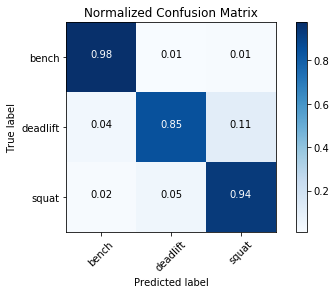

In [98]:
# Model K nearest neighbors

knn_model = KNeighborsClassifier(n_neighbors=1)
knn_model.fit(train_data[key_features], train_labels)

knn_predicts = knn_model.predict(dev_data[key_features])

# Score and Evaluate KNN
get_performance(dev_labels, knn_predicts, labels_names)

## 5.3 Gaussian NB

**Key findings**:

 - Lower accuracy of development data compared to KNN
 - Poor performance for deadlift classification
 - Dealift accuracy is still lagging

### 5.3.1 Model without any customization and validate on development data

Classification report by exercise:
             precision    recall  f1-score   support

      bench       0.91      0.95      0.93      8270
   deadlift       0.85      0.51      0.64      3303
      squat       0.81      0.92      0.86      6551

avg / total       0.86      0.86      0.85     18124

Confusion matrix:
          bench  deadlift  squat
bench      7896        53    321
deadlift    492      1685   1126
squat       257       238   6056


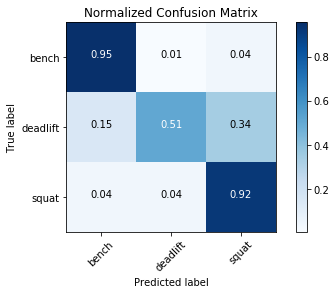

In [99]:
GNB_model = GaussianNB()
GNB_model.fit(train_data[key_features], train_labels)
GNB_predicts = GNB_model.predict(dev_data[key_features])

get_performance(dev_labels, GNB_predicts, labels_names)

## 5.4 Decision Trees

### 5.4.1 Model formation

**Key findings**:

 - Good model performance on development data
 - Deadlift classification again is lagging in accuracy
 - Most of the confusion is between squat and deadlift

In [100]:
# Random Forest model

rf_model = RandomForestClassifier(n_estimators=5)
rf_model.fit(train_data[key_features], train_labels)
rf_dev_predictions = rf_model.predict(dev_data[key_features])

### 5.4.2 Model evaluation on development data

Accuracy on development data: 94.44%
Classification report by exercise:
             precision    recall  f1-score   support

      bench       0.96      0.99      0.98      8270
   deadlift       0.90      0.84      0.87      3303
      squat       0.94      0.94      0.94      6551

avg / total       0.94      0.94      0.94     18124

Confusion matrix:
          bench  deadlift  squat
bench      8156        58     56
deadlift    160      2790    353
squat       137       243   6171


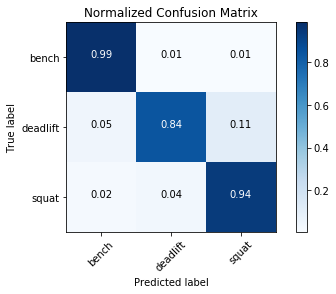

In [105]:
print(f"Accuracy on development data: {rf_model.score(dev_data[key_features], dev_labels)*100:.2f}%")
get_performance(dev_labels, rf_dev_predictions, labels_names)

In [106]:
# What were the most useful features?

importance = rf_model.feature_importances_   # extract feature importance attribute
features = dev_data[key_features].columns
importance_table = pd.DataFrame({'importance': importance, 'features': features})  # make table
importance_table.sort_values('importance', ascending=False, inplace=True)

print(importance_table)

     features  importance
1         ROM    0.397768
2     PeakVel    0.172415
5  weight_lbs    0.152851
3  PeakVelLoc    0.152157
4      RepDur    0.075787
0      AvgVel    0.049022


* The most important feature was ROM - range of motion.  This makes sense, considering the different exercises target different muscle groups and involve different motions
* PeakVel, PeakVelLoc, weight_lbs, and RepDur all had very similar contribution to the decision tree
* The least-important feature was AvgVel - average velocity, which is surprising but may indicate that individuals have very different capabilities

## 5.5 Comparing Models

To show more clearly the performance and robustness of each model, a 20-fold cross-validation is run on the training set.  For each fold, the accuracy is recorded.  This analysis provides an indication of how sensitive the model is to the training set.

* KNN and Random Forests perform very similarly, with accuracies of 94+% and low standard deviations for the 20-fold CV test.
* Gaussian Naive Bayes and Logistic Regression perform noticably worse, with accuracies of 87% and 85%, respectively.
* The variation of the GNB and Logistic models was also higher than KNN and RF, implying that these models may be more sensitive to the specific training data values and outliers.


RandomForest: 0.944370 (0.003543)
KNN: 0.938328 (0.003333)
GNB: 0.869766 (0.007186)
LogisticRegression: 0.849052 (0.009306)


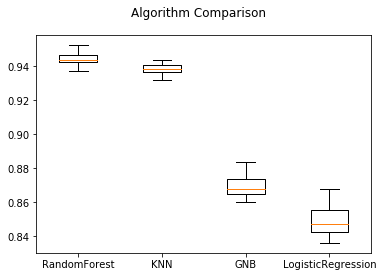

In [107]:
# Comparing models
# with assistance from:   https://machinelearningmastery.com/compare-machine-learning-algorithms-python-scikit-learn/


models = [('RandomForest', rf_model),
          ('KNN', knn_model),
          ('GNB', GNB_model),
          ('LogisticRegression', LogisticRegression())
         ]

results = []
names = []

for name, model in models:
    
    kfold = KFold(n_splits=20, random_state=42)
    cv_results = cross_val_score(model, train_data[key_features], train_labels, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()
              

# 6. Post-Model Custom Logic

As well as optimizing model hyper-parameters, we can also apply custom logic after the final classification. For simplification, our data is stored in rows of reps. This means our models predict on a repetition level. However, knowledge of the domain and the data informs us that repetitions belonging to the same set are performing the same exercise. So ideally, repetitions should all come to the same consensus as to which exercise is being performed. We couldn't identify a simple way to integrate this ensemble logic into our models, so we decided on a custom implementation that is applied after the model classification.

In [121]:
def set_consensus(predictions, set_ids):
    """
    Takes in the original model predictions and their associated
    setIDs. Polls the predictions within a set to establish a 
    consensus. Sets all predictions within a set to the consensus
    label.
    
    Args:
        predictions: predicted labels produced by model
        set_ids: list of setIDs tied to the predictions
    
    Returns:
        consensus_pred: new predictions
    """
    
    consensus_pred = predictions
    
    for i, setID in enumerate(set_ids):
        set_ix = [i for i in range(len(set_ids)) if set_ids[i] == setID]
        set_pred_mode = mode(consensus_pred[set_ix])[0][0]
        consensus_pred[i] = set_pred_mode
        
    return consensus_pred


consensus_pred = set_consensus(knn_predicts, dev_data['setID_ix'].tolist())
correct_ct = 0
for i, prediction in enumerate(consensus_pred):
    if prediction == dev_labels[i]:
        correct_ct += 1
    
print("KNN Accuracy Original vs Ensemble:"
      ,f"{knn_model.score(dev_data[key_features], dev_labels)*100:.2f}% vs {correct_ct / len(dev_labels) * 100:.2f}%")

consensus_pred = set_consensus(GNB_predicts, dev_data['setID_ix'].tolist())
correct_ct = 0
for i, prediction in enumerate(consensus_pred):
    if prediction == dev_labels[i]:
        correct_ct += 1

print("GNB Accuracy Original vs Ensemble:"
      ,f"{GNB_model.score(dev_data[key_features], dev_labels)*100:.2f}% vs {correct_ct / len(dev_labels) * 100:.2f}%")

consensus_pred = set_consensus(rf_dev_predictions, dev_data['setID_ix'].tolist())
correct_ct = 0
for i, prediction in enumerate(consensus_pred):
    if prediction == dev_labels[i]:
        correct_ct += 1

print("RF Accuracy Original vs Ensemble:"
      ,f"{rf_model.score(dev_data[key_features], dev_labels)*100:.2f}% vs {correct_ct / len(dev_labels) * 100:.2f}%")

KNN Accuracy Original vs Ensemble: 93.90% vs 96.31%
GNB Accuracy Original vs Ensemble: 86.28% vs 86.84%
GNB Accuracy Original vs Ensemble: 94.44% vs 96.13%


# Summary

Our group has successfully put together a pipeline where we can rapidly iterate on improving our model. The remaining time before submission will be spent analyzing, iterating, and improving our model's performance.

# Next Steps

- Continue analyzing the data to improve cleaning and feature engineering
- Explore the reasons for poor deadlift classification
- Explore additional machine learning algorithms to determine which is best for this dataset and problem
- Develop a more robust method of scoring performance to guide what needs to be improved in the pipeline and model
- Apply ensemble logic to selected algorithms
- Apply an unsupervised algorithm for Goal #2: Lifter Segmentation

# Open Questions

- What model algorithm gives the best performance and why?
- Do we need to build a separate model for Big 3 lifts with "other" label? 
- What's the best way to handle null values? 
- How should we treat outliers?